## Домашнее задание №1

*работу выполнил* **Пешков Максим** 

группа: **ИАД-4**

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
device = 'cuda'

In [2]:
torch.cuda.is_available()

True

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [3]:
x = torch.rand(2,3)
y = torch.rand(2,3) 

In [4]:
x

tensor([[0.5870, 0.8196, 0.2010],
        [0.8107, 0.6747, 0.5769]])

In [5]:
y

tensor([[0.3540, 0.4849, 0.7522],
        [0.3919, 0.0864, 0.5251]])

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [6]:
torch.empty(2,2, out=x.mm(y.t()))

tensor([[0.7565, 0.4064],
        [1.0482, 0.6790]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [7]:
def relu_forward(x):
    return torch.max(x,torch.zeros_like(x))

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [8]:
def elu_forward(x, alpha=1):
    return torch.max(x,torch.zeros_like(x)) + torch.min(alpha * (torch.exp(x) - torch.ones_like(x)),torch.zeros_like(x))

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [9]:
def lrelu_forward(x, alpha=0.01):
    return torch.max(x,torch.zeros_like(x)) + alpha * torch.min(x,torch.zeros_like(x))

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [10]:
def mish(x):
    return x * torch.tanh(torch.log(1+torch.exp(x)))

In [11]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [12]:
def swish(x):
    return x * torch.sigmoid(x)

In [13]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [14]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [15]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-08, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        #d_param = g
        #buffer = m/v
        for param in filter(lambda x: x.grad is not None, group['params']):
            param_state = self.state[param]
            #Инициализация, но не в отдельной функции, это сложно и не понятно, так проще
            if 'adam_m' not in param_state:
                param_state['adam_m'] = torch.zeros_like(param)
            if 'adam_v' not in param_state:
                param_state['adam_v'] = torch.zeros_like(param)
            if 'step' not in param_state:
                param_state['step'] = 1
            #градиенты посчитаем
            d_param = param.grad
            #обновим накопленные m и v
            param_state['adam_m'] = beta_1*param_state['adam_m'] + (1-beta_1)*d_param
            param_state['adam_v']= beta_2*param_state['adam_v'] + (1-beta_2)*(d_param*d_param)
            m_hat = param_state['adam_m']/(1-beta_1**param_state['step'])
            v_hat = param_state['adam_v']/(1-beta_2**param_state['step'])
            m_hat /= torch.sqrt(v_hat + eps)
            # добавляем сумму градиентов и делаем шаг
            param.add_(m_hat, alpha=-lr)
            param_state['step'] +=1

##### Проверим с правильным Адамом

Для этого возьмем код для проверки с семинара по оптимизации

In [16]:
from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(228)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )


def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        print(f'Iteration {i} loss:', output.item())

In [17]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=10)

Iteration 0 loss: 10.269155502319336
Iteration 1 loss: 10.243722915649414
Iteration 2 loss: 10.218219757080078
Iteration 3 loss: 10.192649841308594
Iteration 4 loss: 10.167011260986328
Iteration 5 loss: 10.141301155090332
Iteration 6 loss: 10.115522384643555
Iteration 7 loss: 10.08967113494873
Iteration 8 loss: 10.063746452331543
Iteration 9 loss: 10.037744522094727


In [18]:
model = get_model()
optim = Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=10)

Iteration 0 loss: 10.269155502319336
Iteration 1 loss: 10.243722915649414
Iteration 2 loss: 10.218219757080078
Iteration 3 loss: 10.192651748657227
Iteration 4 loss: 10.167011260986328
Iteration 5 loss: 10.141301155090332
Iteration 6 loss: 10.115522384643555
Iteration 7 loss: 10.08967113494873
Iteration 8 loss: 10.063746452331543
Iteration 9 loss: 10.037744522094727


Совпало! :)
Это маленькая победа стоила больших трудов, а впереди еще веселее)))

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [19]:
from torch.autograd import Variable

In [20]:
r1 = -np.sqrt(6)/(np.sqrt(784 + 10))
r2 = np.sqrt(6)/(np.sqrt(784 + 10))
weights = Variable(torch.FloatTensor(784, 10).uniform_(r1, r2), requires_grad=True)
intercept = Variable(torch.FloatTensor(1,10).zero_(), requires_grad=True)

In [21]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [22]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval, batch_size=128, num_workers=2, shuffle=False)

Напишите функцию для тренировки логистической регрессии, она должна: 

    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [23]:
def train_logistic_regression(weights, bias, batch, criterion, optimizer):
    loss_list = []
    accuracy_list = []
    images, labels = batch
    images = images.view(-1, 784) #вытягиваем
    prediction = nn.Softmax(dim=-1)(images @ weights + bias) #делаем предсказание логистической регрессии
    loss = criterion(prediction, labels) #считаем лосс
    loss.backward() # подсчитываем градиенты
    optimizer.step() #делаем шаг оптимизации
    optimizer.zero_grad() #обнуляем посчитанные градиенты

    _, predicted = torch.max(prediction.data, 1) #найдем самые вероятные классы для картинок
    total = labels.size(0) #всего количество
    correct = (predicted == labels).sum() #правильно угаданных
    accuracy = 100 * int(correct)/total
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    return loss_list, accuracy_list # возращаем полученные метрики

In [24]:
all_loss = []
all_accuracy = []
val_loss = []
val_accuracy = []
for epoch in tqdm(range(1, 100)):
  for batch in train_dataloader:
    metrics = train_logistic_regression(weights,bias = intercept, batch=batch, criterion = criterion, optimizer=optimizer)
    all_loss.extend(metrics[0])
    all_accuracy.extend(metrics[1])
#считаем метрики на валидации точно также, как делали в функции выше, но не учитываем это в обновление градиент и шаг оптимизатора
  correct = 0
  total = 0
  total_loss = 0
  with torch.no_grad():
    for images_v, labels_v in eval_dataloader:
        images_v = images_v.view(-1, 784)
        outputs = nn.Softmax(dim=-1)(images_v @ weights + intercept)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_v.size(0)
        correct += (predicted == labels_v).sum()
        loss_val = criterion(outputs, labels_v)
        total_loss += loss_val
  accuracy_val = 100 * int(correct)/total
  total_loss /= total
  val_accuracy.extend([accuracy_val])
  val_loss.extend([total_loss])

100%|██████████| 99/99 [08:20<00:00,  5.06s/it]


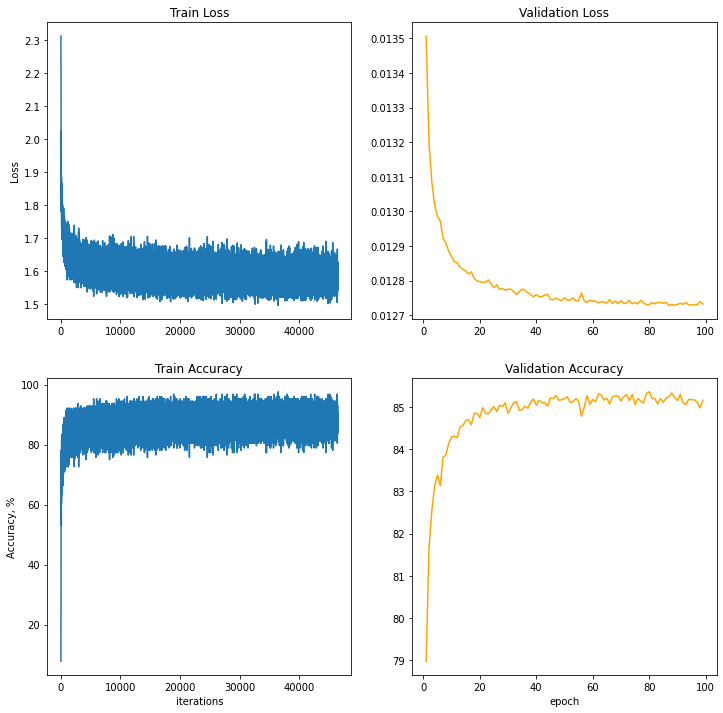

In [25]:
#нарисуем 4 графика метрик
fig, axs = plt.subplots(2, 2, figsize = (12,12))
n_val = np.arange(1, len(val_loss)+ 1)
n_train = np.arange(1, len(all_loss)+ 1)

axs[0, 0].plot(n_train, all_loss)
axs[0,0].set_title('Train Loss')
axs[0,0].set_ylabel('Loss')
axs[1,0].plot(n_train, all_accuracy)
axs[1,0].set_title('Train Accuracy')
axs[1,0].set_xlabel('iterations')
axs[1,0].set_ylabel('Accuracy, %')
axs[0,1].plot(n_val, val_loss, 'orange')
axs[0,1].set_title('Validation Loss')
axs[1,1].plot(n_val, val_accuracy, 'orange')
axs[1,1].set_title('Validation Accuracy')
axs[1,1].set_xlabel('epoch');

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

#### Ответы на вопросы

1) Адам дает несмещенную оценка из-за того, что смотрит не только на настоящую функцию, но и учитывает историю квадрата градиента

2) Модель не переобучилась. Признаками переобучения могли быть падающий тренд у accuracy или возрастающий у loss для валидации. И хотя на 58 эпохе видны эти признаки, следует принимать во внимание, что дальше виден тренд (то есть сходимость) падения loss и роста accuracy (если посмотреть относительно среднего за следующие периоды после 58 эпохи), поэтому такое падение скорей всего показатель такого распределения, при котором полученные веса с учетом истории не очень хорошо работали, но не признак переобучения.

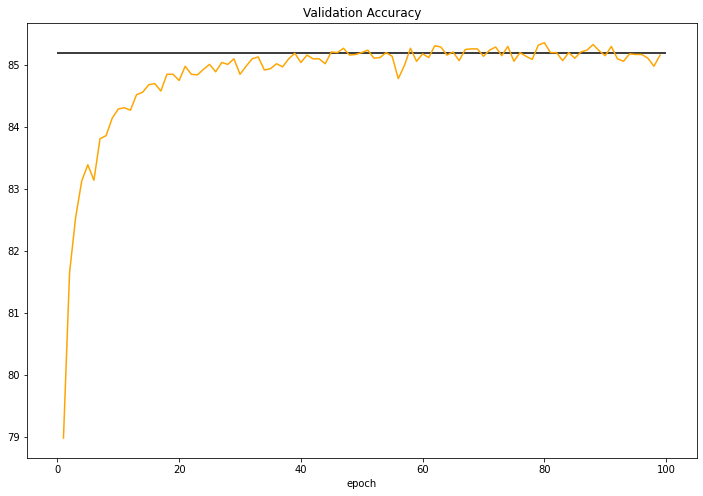

In [70]:
plt.figure(figsize=(12,8))
plt.plot(n_val, val_accuracy, 'orange')
plt.title('Validation Accuracy')
plt.hlines(np.array(val_accuracy[58:]).mean(), 0, 100)
plt.xlabel('epoch');

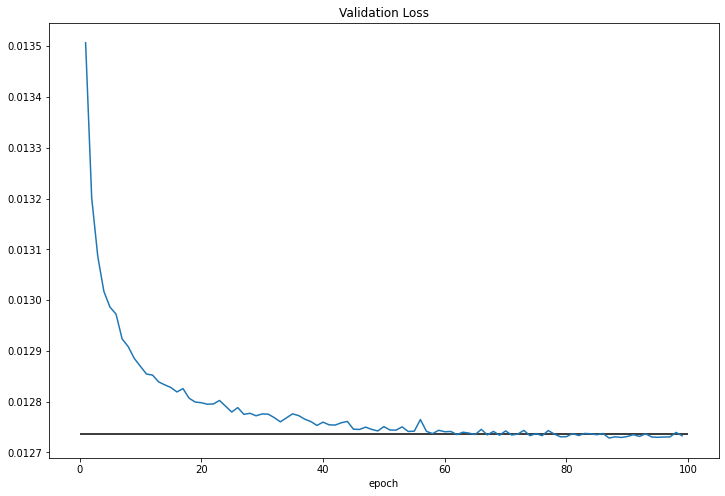

In [69]:
plt.figure(figsize=(12,8))
plt.plot(n_val, val_loss)
plt.title('Validation Loss')
plt.hlines(np.array(val_loss[58:]).mean(), 0, 100)
plt.xlabel('epoch');

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [28]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

Далее возьмем код для цикла обучения и визуализации с семинаров (это не плагиат у других студентов!!!, семинарист Максим Кузнецов разрешил так сделать, хотя я мог и сам, но получилось бы точно также и дольше выполнялся код, но я честно описал комментариями основные моменты в коде)

In [29]:
def plot_history(train_history, val_history, title='loss'): #функция для рисования
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1) #рисуем на каждом шаге для трейна
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:] 
    
    #задаем список, когда была валидация, типо [100, 200, 300..]
    # то есть так задаем когда считать в конце эпох
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2) #рисуем крестики на валидации в конце эпох
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [30]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, epoch):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(epoch):
        model.train() 
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            imgs, labels = imgs.to(device), labels.to(device) #перегоняем на cuda, чтобы было быстрее
            
            #далее делаем все тоже самое, что делали в прошлом задании
            optimizer.zero_grad()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1) #наиболее вероятные классы для картинок
            train_acc += (pred_classes == labels).sum().item() #суммируем совпадения
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy())) #находим непосредственно accuracy для каждой итерации


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad(): #cчитаем метрики для валидации
            for imgs, labels in test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output() #чистим старое
        plot_history(train_loss_log, val_loss_log, 'loss') #рисуем новое
        plot_history(train_acc_log, val_acc_log, 'accuracy') #рисуем новое

        print('Train loss:', train_loss / train_size) #выводим последние метрики на валидации в конце эпох
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

In [31]:
FirstModel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512), 
    nn.ELU(), 
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1) 
)

In [32]:
FirstModel.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): Softmax(dim=-1)
)

In [33]:
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=-1)

        
    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

SecondModel = SecondModel()

In [34]:
SecondModel.to(device)

SecondModel(
  (vgg): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (soft

In [35]:
class ThirdModel(nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()
        self.conv = nn.Conv2d(1, 32, 7)
        self.batch_norm = nn.BatchNorm2d(32)
        self.elu = nn.ELU()
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.linear1 = torch.nn.Linear(in_features=512, out_features=128)
        self.relu = nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)
        self.relu = nn.ReLU()
        self.linear3 = torch.nn.Linear(in_features=64, out_features=64)
        self.relu = nn.ReLU()
        self.output = torch.nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        x = self.elu(self.batch_norm(x))
        x = self.pool(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = nn.Flatten()(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return self.output(x)


ThirdModel = ThirdModel()

In [36]:
ThirdModel.to(device)

ThirdModel(
  (conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

#### Первая модель

##### SGD with momentum

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(FirstModel.parameters(), lr=0.001, momentum=0.9)

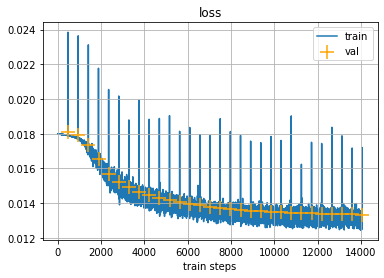

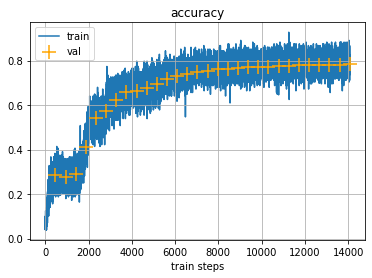

Train loss: 0.013144503768285116
Train acc: 0.79175
Val loss: 0.013334885501861573
Val acc: 0.7839


In [38]:
train_model(FirstModel, criterion, optimizer1, train_dataloader, eval_dataloader, 30) 
#30 эпох, так как после 25 эпохи качество примерно такое же, то есть дальше модель переобучается

##### RMSprop

In [39]:
FirstModel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512), 
    nn.ELU(), 
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1) 
)

In [40]:
FirstModel.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): Softmax(dim=-1)
)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.RMSprop(FirstModel.parameters(), lr=0.001)

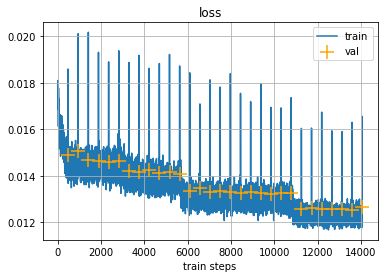

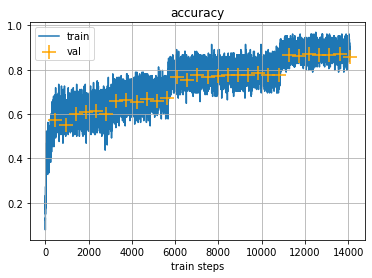

Train loss: 0.012288314344485601
Train acc: 0.8890833333333333
Val loss: 0.012671357429027558
Val acc: 0.8565


In [42]:
train_model(FirstModel, criterion, optimizer2, train_dataloader, eval_dataloader, 30)
# можно было брать даже меньше эпох, модель достаточно быстро за 10 эпох уже обучилась и показывает примерно одно качество

#### Вторая модель

##### SGD with momentum

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer12 = torch.optim.SGD(SecondModel.parameters(), lr=0.01, momentum=0.9)
#выбрал такой шаг, так как иначе модель вообще не обучалась большое количество эпох

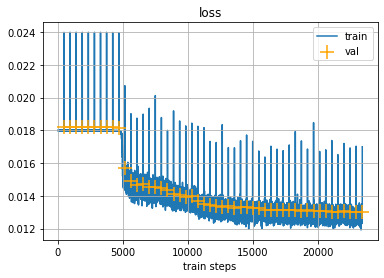

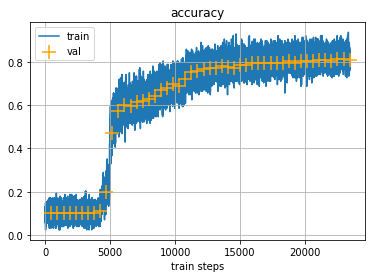

Train loss: 0.012749693604310353
Train acc: 0.8300333333333333
Val loss: 0.013020045387744903
Val acc: 0.8114


In [44]:
train_model(SecondModel, criterion, optimizer12, train_dataloader, eval_dataloader, 50)
#50 эпох, так как долго модель не обучалась, только после 10 эпохи начинает показывать высокое стабильное качество

##### RMSprop

In [51]:
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=-1)

        
    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

SecondModel = SecondModel()

In [52]:
SecondModel.to(device)

SecondModel(
  (vgg): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (soft

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer22 = torch.optim.RMSprop(SecondModel.parameters(), lr=0.001)

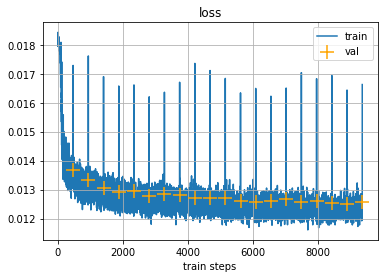

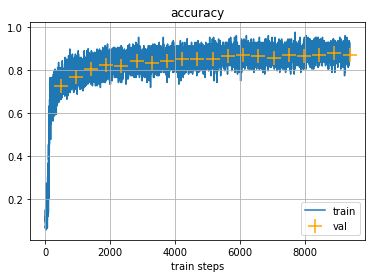

Train loss: 0.01234058521191279
Train acc: 0.8819166666666667
Val loss: 0.012564573168754577
Val acc: 0.8705


In [54]:
train_model(SecondModel, criterion, optimizer22, train_dataloader, eval_dataloader, 20)
#за менее, чем 20 эпох обучается и показывает стабильные высокие метрики качества

#### Третья модель

##### SGD with momentum

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer13 = torch.optim.SGD(ThirdModel.parameters(), lr=0.001, momentum=0.9)

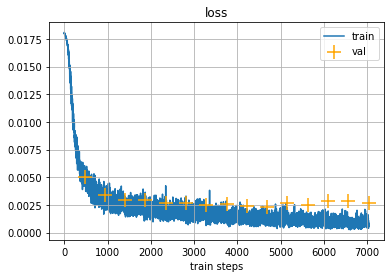

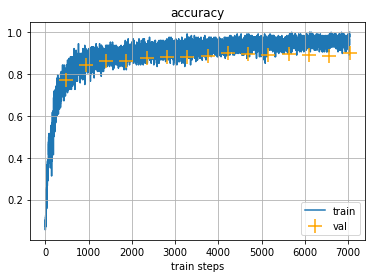

Train loss: 0.0008807479159906506
Train acc: 0.9584666666666667
Val loss: 0.0026354061514139177
Val acc: 0.8987


In [56]:
train_model(ThirdModel, criterion, optimizer13, train_dataloader, eval_dataloader, 15)
#достаточно быстро обучается и показывает высокую стабильную accuracy, причем уже после 10 эпох начинает переобучаться (лосс на валидации немного растет)

##### RMSprop

In [57]:
class ThirdModel(nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()
        self.conv = nn.Conv2d(1, 32, 7)
        self.batch_norm = nn.BatchNorm2d(32)
        self.elu = nn.ELU()
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.linear1 = torch.nn.Linear(in_features=512, out_features=128)
        self.relu = nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)
        self.relu = nn.ReLU()
        self.linear3 = torch.nn.Linear(in_features=64, out_features=64)
        self.relu = nn.ReLU()
        self.output = torch.nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        x = self.elu(self.batch_norm(x))
        x = self.pool(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = nn.Flatten()(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return self.output(x)


ThirdModel = ThirdModel()

In [58]:
ThirdModel.to(device)

ThirdModel(
  (conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer23 = torch.optim.RMSprop(ThirdModel.parameters(), lr=0.001)

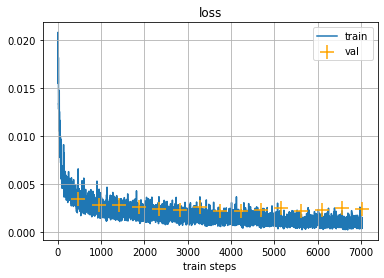

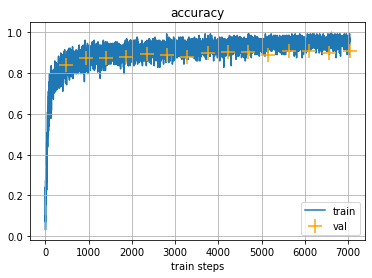

Train loss: 0.0009485399805630246
Train acc: 0.9560333333333333
Val loss: 0.002432536727935076
Val acc: 0.9096


In [60]:
train_model(ThirdModel, criterion, optimizer23, train_dataloader, eval_dataloader, 15)

#### Вывод

Построенные модели отличались уровнем сложности и глубиной (первая модель-полносвязная, вторая модель с VGG блоком, третья модель - подобие ResNet).

Более того, к ним были применены разные оптимизаторы: SGD with momentum, RMSprop, последний считается лучше, так как в нем регулируются скорости изменений различных весов (адаптивный шаг оптимизации), что способствует общей оптимизации всех параметров.

Таким образом, по построенным моделям и визуализации их метрик видно, что более глубокие модели показывают лучше качество (хотя для VGG требуется больше эпох), так как они учитывают больше паттернов и оптимизируют больше количество весов. Также модели с RMSprop лучше показывают качество, что подтверждает более сложную и умную конструкцию этого оптимизатора относительно SGD with momentum.

А самой лучшей моделью стала третья с RMSprop (ResNet with RMSprop), показывая после 15 эпох качество в 91% accuracy.